In [1]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Packages
from numpy import array, hstack
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Flatten, TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.metrics import mean_squared_error
from math import sqrt

[*********************100%***********************]  1 of 1 completed


Text(0, 0.5, 'Prices ($)')

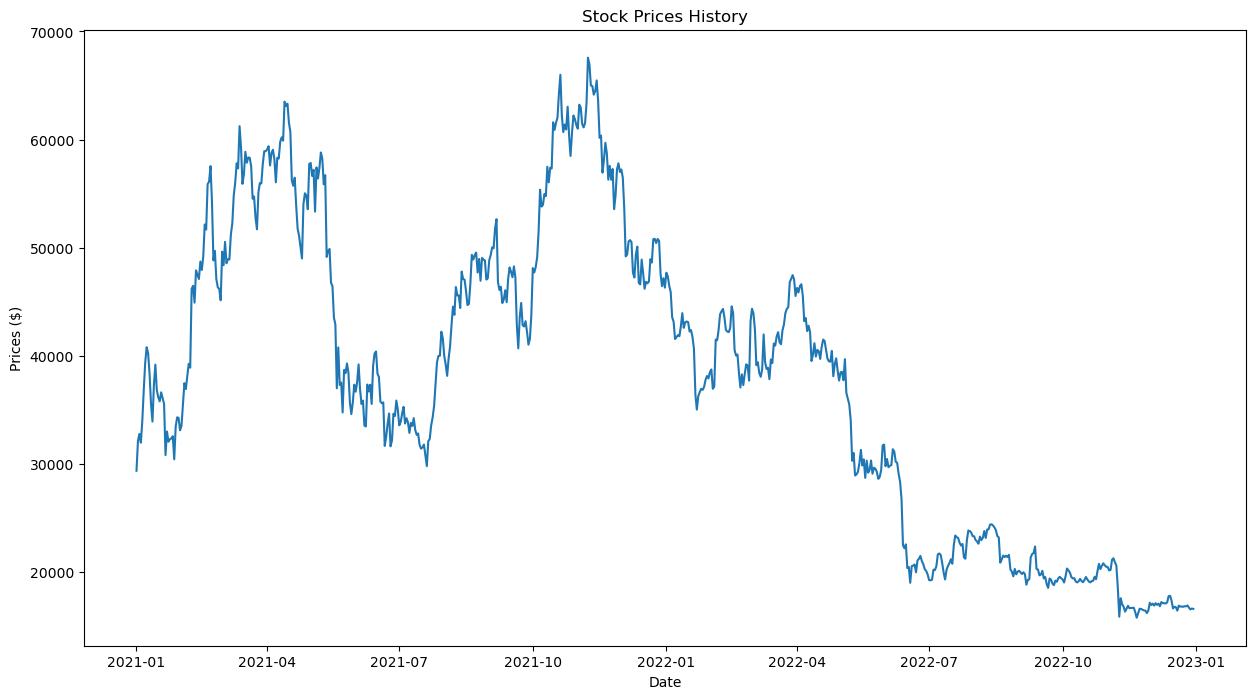

In [3]:
stock_data = yf.download('BTC-USD', start='2021-01-01', end='2022-12-31')

plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [4]:
stock_data.head(1)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359


In [5]:
close_prices = stock_data['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [7]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [8]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
524/524 [==============================] - 11s 16ms/step - loss: 0.0058
Epoch 2/3
524/524 [==============================] - 8s 16ms/step - loss: 0.0026
Epoch 3/3
524/524 [==============================] - 8s 16ms/step - loss: 0.0024


In [11]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

5/5 [==============================] - 1s 19ms/step


252.80542834051724

# CNN LSTM

In [5]:
# Split Function
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix > len(sequences):
            break
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [6]:
sequences = data = pd.DataFrame({'log_return_open':[2**i for i in range(1,5)],
                     'log_return_close':[3**i for i in range(1,5)],
                     'log_volume':[5**i for i in range(1,5)] })
sequences

,log_return_open,log_return_close,log_volume
0,2,3,5
1,4,9,25
2,8,27,125
3,16,81,625


In [90]:
n_features

1

In [88]:
n_steps = 2
n_seq = 2
n_features = int((len(sequences.columns)-1)/2)
X,y= split_sequences(np.array(sequences), n_steps)

X.reshape((X.shape[0], n_seq, n_steps, n_features))

array([[[[ 2],
         [ 3]],

        [[ 4],
         [ 9]]],


       [[[ 4],
         [ 9]],

        [[ 8],
         [27]]],


       [[[ 8],
         [27]],

        [[16],
         [81]]]], dtype=int64)

In [8]:
log_return_open = np.diff(np.log(stock_data['Open']))
log_return_close = np.diff(np.log(stock_data['Close']))
log_volume = np.log(stock_data['Volume'])

# Prepare the data

data = pd.DataFrame({'log_return_open':log_return_open,
                     'log_volume':log_volume[1:],
                     'log_return_close':log_return_close})

dataset = np.array(data)
dataset = dataset.reshape((len(dataset), len(data.columns)))

In [9]:
# Set parameters
n_steps = 1
n_seq = 2
n_features = int((len(data.columns)-1)/2)

# Define Model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 1, 64)      128       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 1, 64)      0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 64)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                23000     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                        

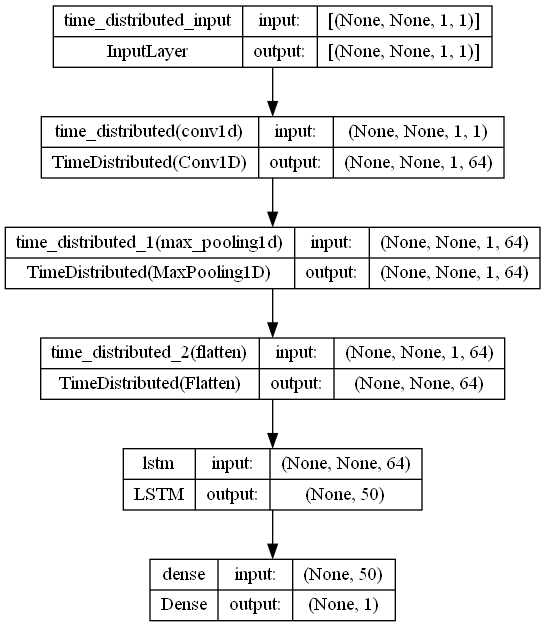

In [10]:
from tensorflow.keras.utils import plot_model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
train = dataset[]
test=dataset[w:w+30,:len(data.columns)-1]

X, y = split_sequences(train, n_steps)
X = X.reshape((X.shape[0], n_seq, n_steps, n_features))

model.fit(X, y, epochs=20, verbose=0)

In [ ]:
# 3 - Forecast
y_actual = dataset[1210:,len(data.columns)-1:] # Real values for accuracy measurement
finalresults=pd.DataFrame()

# Increasing window cross-validation 
for k in range (10):
    result=pd.DataFrame()
    for w in range(1210, 1510, 30):
        train=dataset[:w]
        X, y = split_sequences(train, n_steps)
        X = X.reshape((X.shape[0], n_seq, n_steps, n_features))
        test=dataset[w:w+30,:len(data.columns)-1]
        model.fit(X, y, epochs=200, verbose=0)
    
        for i in range(30):
            aaa = test[i].reshape((1, n_seq, n_steps, n_features))
            yhat = pd.DataFrame(model.predict(aaa, verbose=0))
            result=pd.concat((result, yhat))
    finalresults=pd.concat((finalresults, result), axis=1)

y_mean=pd.DataFrame(finalresults.mean(axis=1))
print(sqrt(mean_squared_error(y_actual, y_mean)))

C:\Users\BATTACH\AppData\Local\Temp\ipykernel_17412\154904543.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


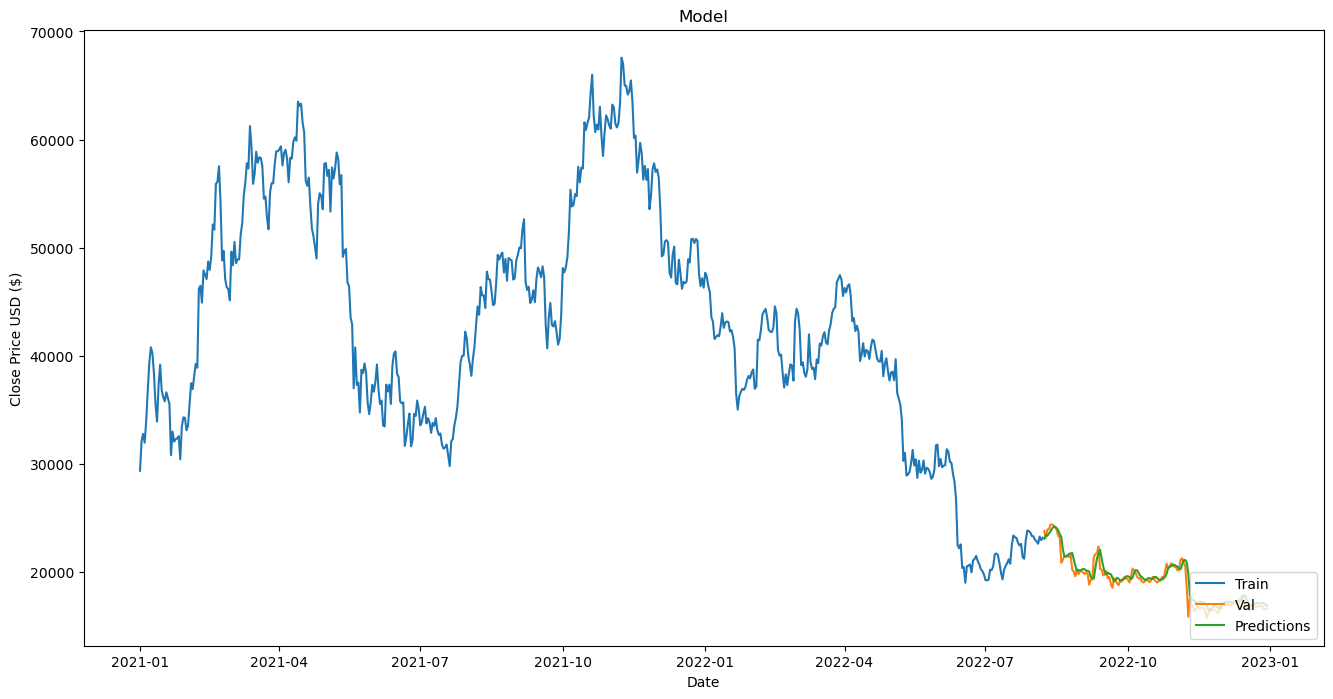

In [12]:
data = stock_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()